# AB Test in five simple steps
> A-B test and plots with explanations to understand the basics

- toc: true
- badges: true
- comments: true
- categories: [ABTest]
- author: "<a href='https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f'>Nguyen Ngo</a>"
- image:

## Outline for A/B Tests
1. Set up the experiment.
2. Run the test and record the success rate for each group.
3. Plot the distribution of the difference between the two samples.
4. Calculate the statistical power.
5. Evaluate how sample size affects A/B tests.

In [27]:
import scipy.stats as scs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

### Stats

In [26]:
def pooled_prob(N_A, N_B, X_A, X_B):
    """Returns pooled probability for two samples"""
    return (X_A + X_B) / (N_A + N_B)


def pooled_SE(N_A, N_B, X_A, X_B):
    """Returns the pooled standard error for two samples"""
    p_hat = pooled_prob(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE


def confidence_interval(sample_mean=0, sample_std=1, sample_size=1,
                        sig_level=0.05):
    """Returns the confidence interval as a tuple"""
    z = z_val(sig_level)

    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)


def z_val(sig_level=0.05, two_tailed=True):
    """Returns the z value for a given significance level"""
    z_dist = scs.norm()
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    z = z_dist.ppf(area)

    return z


def ab_dist(stderr, d_hat=0, group_type='control'):
    """Returns a distribution object depending on group type
    Examples:
    Parameters:
        stderr (float): pooled standard error of two independent samples
        d_hat (float): the mean difference between two independent samples
        group_type (string): 'control' and 'test' are supported
    Returns:
        dist (scipy.stats distribution object)
    """
    if group_type == 'control':
        sample_mean = 0

    elif group_type == 'test':
        sample_mean = d_hat

    # create a normal distribution which is dependent on mean and std dev
    dist = scs.norm(sample_mean, stderr)
    return dist


def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        bcr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        mde (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (bcr + bcr+mde) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N


def p_val(N_A, N_B, p_A, p_B):
    """Returns the p-value for an A/B test"""
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

### Plot utils

In [28]:
def plot_norm_dist(ax, mu, std, with_CI=False, sig_level=0.05, label=None):
    """Adds a normal distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        std (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    y = scs.norm(mu, std).pdf(x)
    ax.plot(x, y, label=label)

    if with_CI:
        plot_CI(ax, mu, std, sig_level=sig_level)

In [29]:
def plot_binom_dist(ax, n, p, label=None):
    """Adds a binomial distribution to the axes provided
    Example:
        plot_binom_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(0, n, n+1)
    y = scs.binom(n, p).pmf(x)
    ax.plot(x, y, label=label)

In [47]:
def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calculates the two-tailed confidence interval and adds the plot to
    an axes object.
    Example:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    Parameters:
        ax (matplotlib axes)
        mu (float): mean
        s (float): standard deviation
    Returns:
        None: the function adds a plot to the axes object provided
    """
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)

In [48]:
def plot_null(ax, stderr):
    """Plots the null hypothesis distribution where if there is no real change,
    the distribution of the differences between the test and the control groups
    will be normally distributed.
    The confidence band is also plotted.
    Example:
        plot_null(ax, stderr)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)

In [49]:
def plot_alt(ax, stderr, d_hat):
    """Plots the alternative hypothesis distribution where if there is a real
    change, the distribution of the differences between the test and the
    control groups will be normally distributed and centered around d_hat
    The confidence band is also plotted.
    Example:
        plot_alt(ax, stderr, d_hat=0.025)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, d_hat, stderr, label="Alternative")

In [50]:
def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

In [51]:
def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, d_hat, 'test')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha=0.25,
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='green', alpha=0.25,
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha=0.25,
                        where=(x < right))
        ax.text(-3 * stderr, null.pdf(0),
                'beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

In [52]:
def zplot(area=0.95, two_tailed=True, align_right=False):
    """Plots a z distribution with common annotations
    Example:
        zplot(area=0.95)
        zplot(area=0.80, two_tailed=False, align_right=True)
    Parameters:
        area (float): The area under the standard normal distribution curve.
        align (str): The area under the curve can be aligned to the center
            (default) or to the left.
    Returns:
        None: A plot of the normal distribution with annotations showing the
        area under the curve and the boundaries of the area.
    """
    # create plot object
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots()
    # create normal distribution
    norm = scs.norm()
    # create data points to plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # code to fill areas
    # for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
        ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')

        ax.fill_between(x, 0, y, color='grey', alpha=0.25,
                        where=(x > left) & (x < right))
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), fontsize=12,
                 rotation=90, va="bottom", ha="right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                 fontsize=12, rotation=90, va="bottom", ha="left")
    # for one-tailed tests
    else:
        # align the area to the right
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha=0.25,
                            where=x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left),
                     fontsize=12, rotation=90, va="bottom", ha="right")
        # align the area to the left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha=0.25,
                            where=x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                     fontsize=12, rotation=90, va="bottom", ha="left")

    # annotate the shaded area
    plt.text(0, 0.1, "shaded area = {0:.3f}".format(area), fontsize=12,
             ha='center')
    # axis labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()

In [53]:
def abplot_CI_bars(N, X, sig_level=0.05, dmin=None):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        N (list or tuple): sample size for all groups
        X (list or tuple): number of conversions for each variant
        sig_level (float): significance level
        dmin (float): minimum desired lift; a red and green dashed lines are
            shown on the plot if dmin is provided.
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # get control group values
    N_A = N[0]
    X_A = X[0]

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(1, len(N)):
        X_B = X[idx]
        N_B = N[idx]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)

    y = np.arange(len(N)-1)

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # plot veritcal dashed lines if dmin is provided
    if dmin is not None:
        ax.axvline(-dmin, c='red', linestyle='--', alpha=0.75)
        ax.axvline(dmin, c='green', linestyle='--', alpha=0.75)

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['variant{}'.format(idx+1) for idx in range(len(N)-1)]
    plt.yticks(np.arange(len(N)-1), labels)

In [54]:
def funnel_CI_plot(A, B, sig_level=0.05):
    """Returns a confidence interval bar plot for multivariate tests
    Parameters:
        A (list of tuples): (sample size, conversions) for control group funnel
        B (list of tuples): (sample size, conversions) for test group funnel
        sig_level (float): significance level
    Returns:
        None: A plot of the confidence interval bars is returned inline.
    """

    # initiate plot object
    fig, ax = plt.subplots(figsize=(12, 3))

    # initiate containers for standard error and differences
    SE = []
    d = []
    # iterate through X and N and calculate d and SE
    for idx in range(len(A)):
        X_A = A[idx][1]
        N_A = A[idx][0]
        X_B = B[idx][1]
        N_B = B[idx][0]
        d.append(X_B / N_B - X_A / N_A)
        SE.append(pooled_SE(N_A, N_B, X_A, X_B))

    # convert to numpy arrays
    SE = np.array(SE)
    d = np.array(d)
    print(d)

    y = np.arange(len(A))

    # get z value
    z = z_val(sig_level)
    # confidence interval values
    ci = SE * z

    # bar to represent the confidence interval
    ax.hlines(y, d-ci, d+ci, color='blue', alpha=0.35, lw=10, zorder=1)
    # marker for the mean
    ax.scatter(d, y, s=300, marker='|', lw=10, color='magenta', zorder=2)

    # vertical line to represent 0
    ax.axvline(0, c='grey', linestyle='-')

    # invert y axis to show variant 1 at the top
    ax.invert_yaxis()
    # label variants on y axis
    labels = ['metric{}'.format(idx+1) for idx in range(len(A))]
    plt.yticks(np.arange(len(A)), labels)

## 1. Set Up The Experiment
We will run an A/B test for a hypothetical company that is trying to increase the amount of users that sign up for a premium account. The goal of running an A/B test is to evaluate if a change in a website will lead to improved performance in a specific metric. You may decide to test very simple alternatives such as changing the look of a single button on a webpage or testing different layouts and headlines. You could also run an A/B test on multi-step processes which may have many differences. Examples of this include the steps required in signing up a new user or processing the sale on an online marketplace. A/B testing is a huge subject and there are many techniques and rules on setting up an experiment.

### Baseline Conversion Rate and Lift
Before running the test, we will know the baseline conversion rate and the desired lift or increase in signups that we would like to test. The baseline conversion rate is the current rate at which we sign up new users under the existing design. For our example, we want to use our test to confirm that the changes we make to our signup process will result in at least a 2% increase in our sign up rate. We currently sign up 10 out of 100 users who are offered a premium account.

In [71]:
# code examples presented in Python
bcr = 0.10  # baseline conversion rate
d_hat = 0.02  # difference between the groups

### Control Group (A) and Test Group (B)
Typically, the total number of users participating in the A/B test make up a small percentage of the total amount of users. Users are randomly selected and assigned to either a control group or a test group. The sample size that you decide on will determine how long you might have to wait until you have collected enough. For example, websites with large audiences may be able to collect enough data very quickly, while other websites may have to wait a number of weeks. There are some events that happen rarely even for high-traffic websites, so determining the necessary sample size will inform how soon you can assess your experiment and move on to improving other metrics.

Initially, we will collect 1000 users for each group and serve the current signup page to the control group and a new signup page to the test group.

In [72]:
# A is control; B is test
N_A = 1000
N_B = 1000

## 2. Run the Test
Because this is a hypothetical example, we will need “fake” data to work on. We will use a function that will generate data for our simulation.

In [73]:
def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    """Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    # distribute events based on proportion of group size
    group_bern = scs.bernoulli(N_A / (N_A + N_B))

    # initiate bernoulli distributions from which to randomly sample
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [76]:
ab_data = generate_data(N_A, N_B, bcr, bcr+d_hat)
ab_data.head(10)

,group,converted
0,A,0
1,B,0
2,A,0
3,B,0
4,A,0
5,B,0
6,A,0
7,A,0
8,B,0
9,A,0


The converted column indicates whether a user signed up for the premium service or not with a 1 or 0, respectively. The A group will be used for our control group and the B group will be our test group.

Let’s look at a summary of the results using the pivot table function in Pandas.

In [77]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')
ab_summary

,converted,total,rate
group,,,
A,103,1001,0.102897
B,126,999,0.126126


It looks like the difference in conversion rates between the two groups is 0.024 which is more than the lift we initially wanted of 0.02. This is a good sign that we should adopt the new design, but this is not enough evidence for us to confidently accept the new design. At this point we have not measured how confident we are in this result. This can be mitigated by looking at the distributions of the two groups.

## 3. Compare the Two Groups
We can compare the two groups by plotting the distribution of the control group and calculating the probability of getting the result from our test group. We can assume that the distribution for our control group is binomial because the data is a series of Bernoulli trials, where each trial only has two possible outcomes (similar to a coin flip).

In [78]:
A_converted = ab_summary.loc['A','converted']
A_total = ab_summary.loc['A','total']
A_cr = ab_summary.loc['A','rate']

B_converted = ab_summary.loc['B','converted']
B_total = ab_summary.loc['B','total']
B_cr = ab_summary.loc['B','rate']

Text(0, 0.5, 'probability')

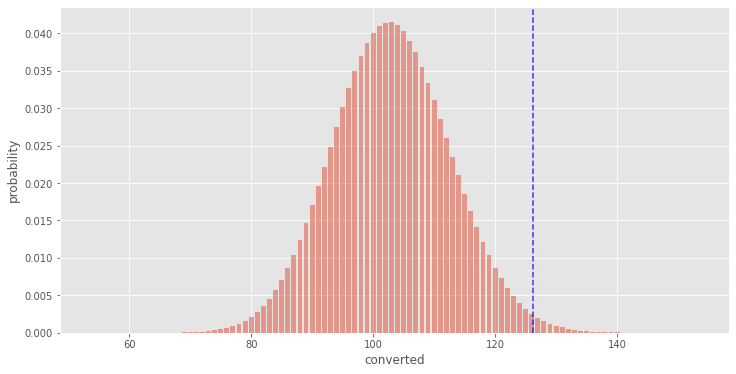

In [79]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, A_cr).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=B_cr * A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

The distribution for the control group is shown in red and the result from the test group is indicated by the blue dashed line. We can see that the probability of getting the result from the test group is very high. However, the probability does not convey the confidence level of the results. It does not take the sample size of our test group into consideration. Intuitively, we would feel more confident in our results as our sample sizes grow larger. Let’s continue and plot the test group results as a binomial distribution and compare the distributions against each other.

### Binomial distribution

Text(0, 0.5, 'probability')

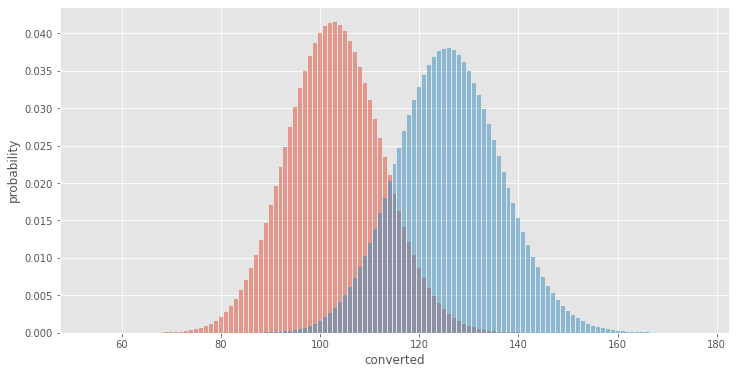

In [80]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, A_cr).pmf(xA)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, B_cr).pmf(xB)
ax.bar(xB, yB, alpha=0.5)
plt.xlabel('converted')
plt.ylabel('probability')

### Compare the Null Hypothesis vs. the Alternative Hypothesis

Let’s start off by defining the null hypothesis and the alternative hypothesis.
- The null hypothesis is the position that the change in the design made for the test group would result in no change in the conversion rate.
- The alternative hypothesis is the opposing position that the change in the design for the test group would result in an improvement (or reduction) in the conversion rate.

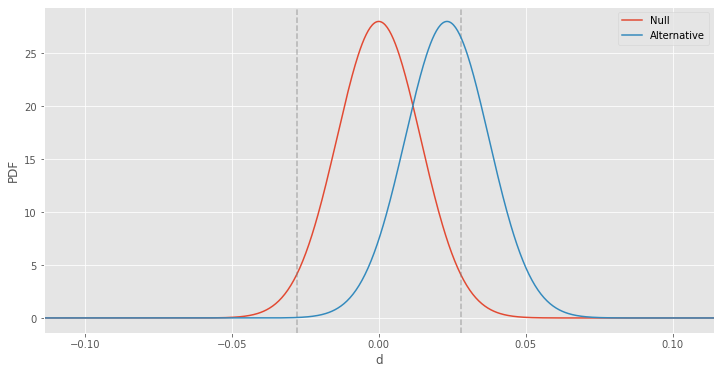

In [81]:
# define the parameters for abplot()
# use the actual values from the experiment for bcr and d_hat
# p_A is the conversion rate of the control group
# p_B is the conversion rate of the test group
bcr = A_cr
d_hat = B_cr - A_cr
abplot(N_A, N_B, bcr, d_hat)

Fortunately, both curves are identical in shape, so we can just compare the distance between the means of the two distributions. We can see that the alternative hypothesis curve suggests that the test group has a higher conversion rate than the control group. This plot also can be used to directly determine the statistical power.

## 4. Statistical Power and Significance Level
I think it is easier to define statistical power and significance level by first showing how they are represented in the plot of the null and alternative hypothesis. We can return a visualization of the statistical power by adding the parameter show_power=True

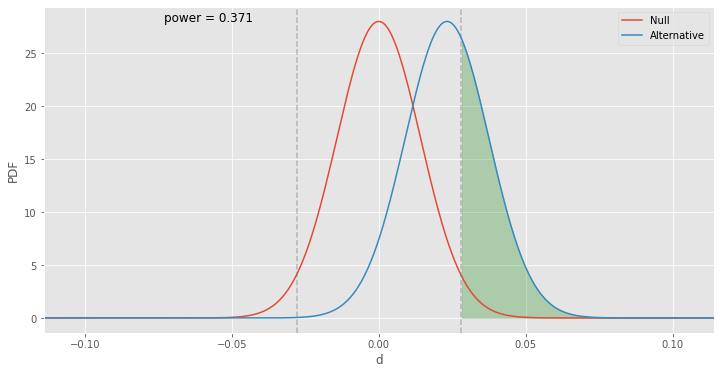

In [82]:
abplot(N_A, N_B, bcr, d_hat, show_power=True)

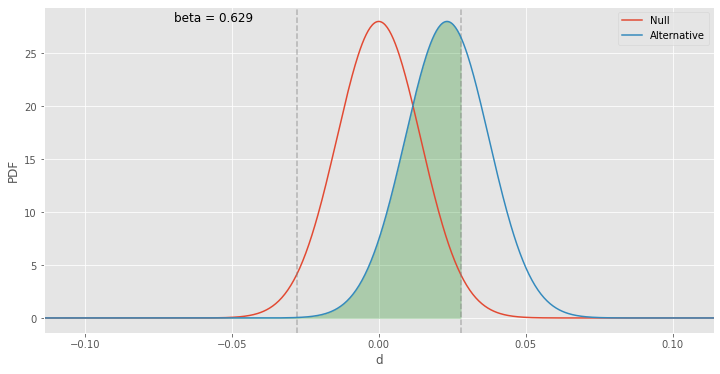

In [83]:
abplot(N_A, N_B, bcr, d_hat, show_beta=True)

The gray dashed line that divides the area under the alternative curve into two also directly segments the area associated with the significance level, often denoted with the greek letter alpha.

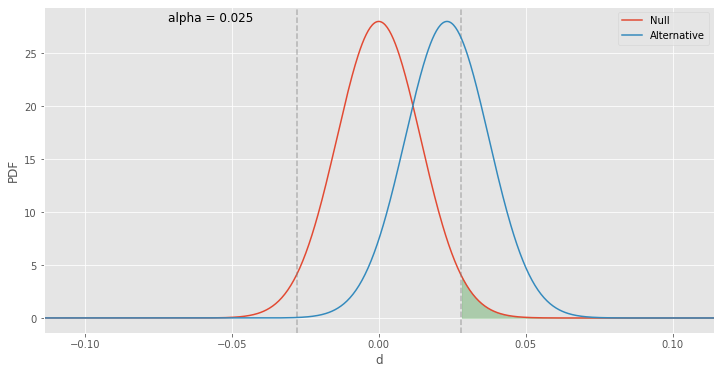

In [84]:
abplot(N_A, N_B, bcr, d_hat, show_alpha=True)

Experiments are typically set up for a minimum desired power of 80%. If our new design is truly better, we want our experiment to show that there is at least an 80% probability that this is the case. We know that if we increase the sample size for each group, we will decrease the pooled variance for our null and alternative hypothesis. This will make our distributions much narrower and may increase the statistical power. Let’s take a look at how sample size will directly affect our results.

## 5. Sample Size
If we run our test again with a sample size of 2000 instead of 1000 for each group, we get the following results.

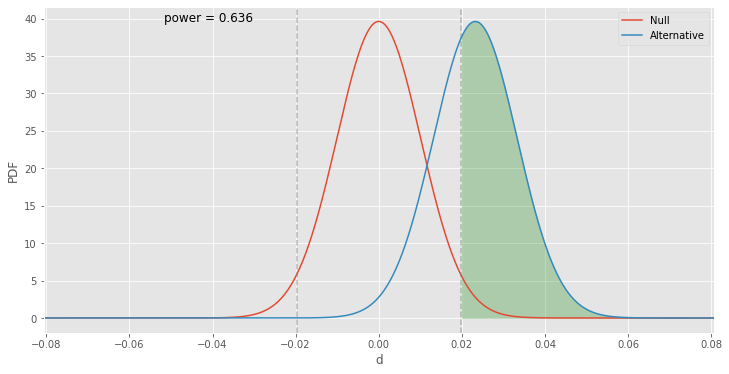

In [85]:
abplot(2000, 2000, bcr, d_hat, show_power=True)

Many people calculate Z from tables such as those shown here and here. However, I am more of a visual learner and I like to refer to the plot of the Z-distribution from which the values are derived.

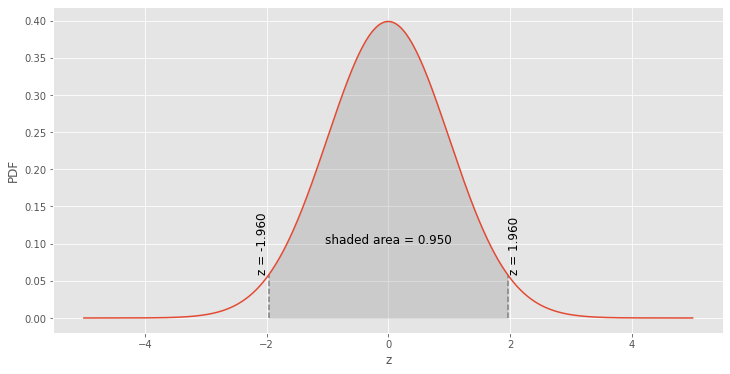

In [62]:
zplot()

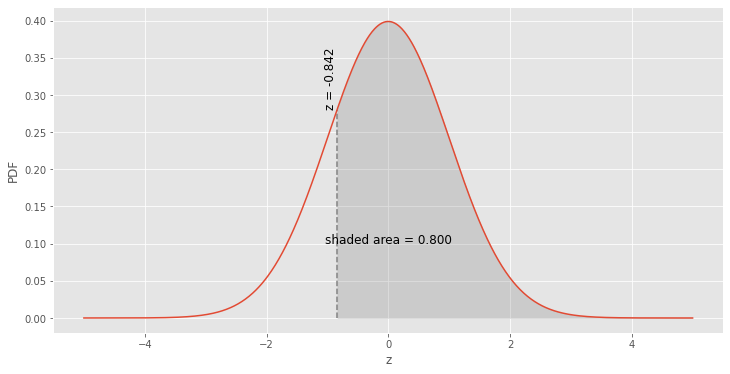

In [65]:
zplot(0.80,False,True)

In [86]:
min_sample_size(bcr=0.10, mde=0.02)

3842.026629963879

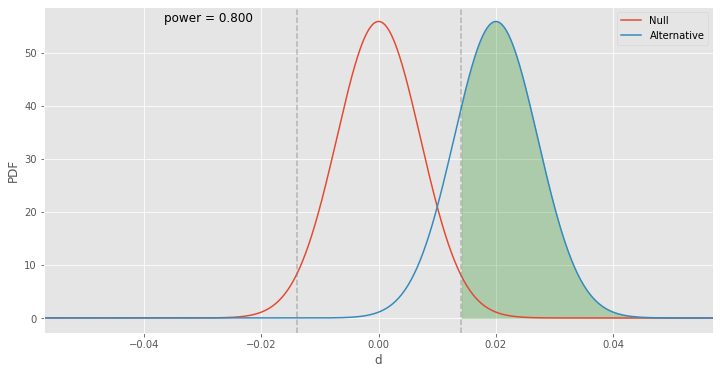

In [87]:
abplot(3843, 3843, 0.10, 0.02, show_power=True)

The calculated power for this sample size was approximately 0.80. Therefore, if our design change had an improvement in conversion of about 2 percent, we would need at least 3843 samples in each group for a statistical power of at least 0.80.

That was a very long but basic walkthrough of A/B tests. Once you have developed an understanding and familiarity with the procedure, you will probably be able to run an experiment and go directly to the plots for the null and alternative hypothesis to determine if your results achieved enough power. By calculating the minimum sample size you need prior to the experiment, you can determine how long it will take to get the results back to your team for a final decision.